In [1]:
import json
import os
from typing import List, Dict
import numpy as np
import networkx as nx
from gtda.homology import VietorisRipsPersistence
import matplotlib.pyplot as plt
from gtda.plotting import plot_diagram


In [2]:
def load_game_data(file_path: str) -> List[Dict]:
    with open(file_path, 'r') as file:
        game_data = json.load(file)
    return game_data

def load_all_games(data_dir: str) -> List[List[Dict]]:
    all_games = []
    goal_counts = []
    for filename in os.listdir(data_dir):
        if filename.endswith('.json'):
            file_path = os.path.join(data_dir, filename)
            game = load_game_data(file_path)
            all_games.append(game)
            goal_counts.append(int(filename.split('_')[-1]) / int(filename.split('_')[-2]))
    return all_games, goal_counts

In [3]:
# Create passing network, normalizing edges between 0 and 1

def construct_adjacency_matrix(game: List[Dict]) -> nx.Graph:
    G = nx.Graph()

    # Find the maximum pass count to normalize edge weights between 0 and 1
    max_count = max(pass_info["count"] for player in game for pass_info in player["passes"])

    # Add nodes with their positions
    for player in game:
        G.add_node(player['name'], pos=(player['x'], player['y']))
    
    # Add edges with normalized weights
    for player in game:
        for pass_info in player["passes"]:
            player1 = player["name"]
            player2 = pass_info["name"]
            count = pass_info["count"]
            edge_weight = count / max_count  # Normalize weight

            G.add_edge(player1, player2, weight=edge_weight)

    return G

def visualize_passing_network(G):
    pos = nx.get_node_attributes(G, 'pos')
    weights = [G[u][v]['weight'] for u, v in G.edges()]  # Get edge weights

    plt.figure(figsize=(10, 8))
    
    # Draw the network with normalized edge weights
    nx.draw_networkx_nodes(G, pos, node_size=700, node_color='lightblue')
    nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')
    nx.draw_networkx_edges(G, pos, width=weights, edge_color='gray')
    
    plt.title("Passing Network Graph (Normalized Edge Weights)")
    plt.axis('off')
    plt.show()
    

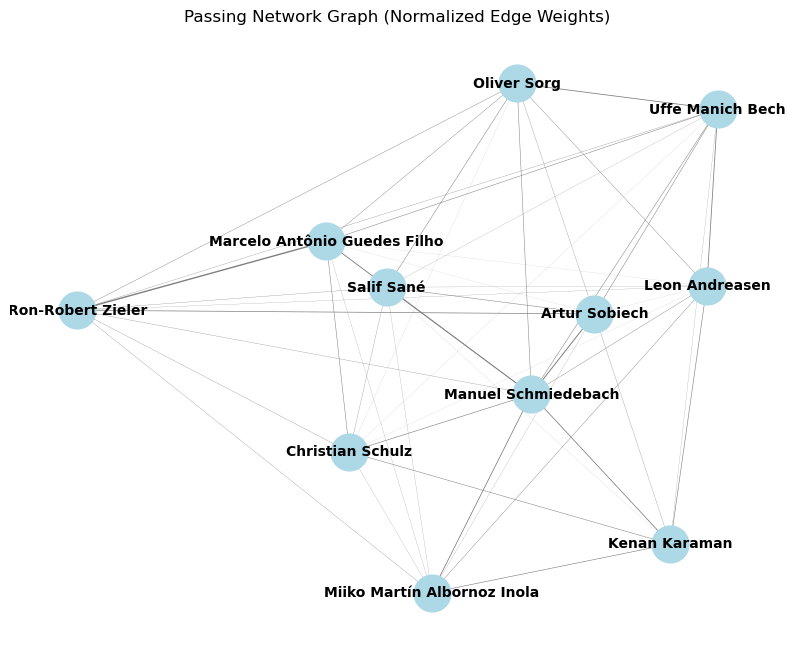

In [4]:
example_game = load_game_data('../data/2015-2016/1-Bundesliga/3890380_Hannover-96_3_70.json')

G_example = construct_adjacency_matrix(example_game)
visualize_passing_network(G_example)

In [5]:
def graph_to_adjacency_matrix(G):
    nodes = sorted(G.nodes())
    adj_matrix_noinf = nx.to_numpy_array(G, nodelist=nodes, weight='weight')
    adj_matrix = np.where(adj_matrix_noinf == 0, np.inf, adj_matrix_noinf)
    np.fill_diagonal(adj_matrix, 0)
    return adj_matrix, nodes

In [6]:
adj_matrix, nodes = graph_to_adjacency_matrix(G_example)
print("Adjacency Matrix:")
print(adj_matrix)
print("\nNodes Order:")
print(nodes)

Adjacency Matrix:
[[0.                inf 0.21428571 0.07142857 0.71428571 0.07142857
  0.14285714 0.21428571 0.5        0.35714286 0.35714286]
 [       inf 0.         0.35714286 0.07142857 0.42857143 0.35714286
  0.14285714 0.07142857 0.21428571 0.21428571 0.07142857]
 [0.21428571 0.35714286 0.         0.42857143 0.57142857        inf
  0.42857143        inf        inf 0.07142857 0.14285714]
 [0.07142857 0.07142857 0.42857143 0.         0.28571429 0.07142857
  0.28571429 0.28571429 0.14285714 0.14285714 0.57142857]
 [0.71428571 0.42857143 0.57142857 0.28571429 0.         0.57142857
  0.57142857 0.35714286 0.21428571 0.57142857 0.35714286]
 [0.07142857 0.35714286        inf 0.07142857 0.57142857 0.
  0.14285714 0.28571429 1.         0.14285714 0.35714286]
 [0.14285714 0.14285714 0.42857143 0.28571429 0.57142857 0.14285714
  0.                inf 0.21428571 0.14285714        inf]
 [0.21428571 0.07142857        inf 0.28571429 0.35714286 0.28571429
         inf 0.         0.28571429 0.357

In [7]:
vr_persistence = VietorisRipsPersistence(
        metric="precomputed",
        homology_dimensions=[0, 1],  # Compute H0 and H1
        collapse_edges=True  # Handle disconnected graphs
    )

diagrams = vr_persistence.fit_transform([adj_matrix])[0]
plot_diagram(diagrams)
